# Pattern Recognition & Machine Learning Project

*Authors*: Aristeidis Daskalopoulos (AEM: 10640), Georgios Rousomanis (AEM: 10703)

----

<center>
This notebook contains the solution for Part D.
</center>


## Intro

The goal of this part is to classify the feature vectors in `datasetTest.csv` into one of five classes ($\omega_1, \omega_2, \ldots, \omega_5$), using a model trained on `datasetTV.csv`. The training dataset contains $8743$ examples (*samples and their corresponding labels*), with each sample represented by a feature vector of dimentionality $224$. 

Our objective is to implement, validate, and test a model capable of achieving high accuracy in predicting the correct class for a given sample. 

To begin, we must first load the data.


In [1]:
import numpy as np

file_path = "datasetTV.csv"
data = np.loadtxt(file_path, delimiter=',')

X = data[:, :-1]              # Extract the features
y = data[:, -1].astype(int)   # Extract the labels

classes, counts = np.unique(y, return_counts=True)
print(f'Classes: {classes}')
print(f'Counts: {counts}')

Classes: [1 2 3 4 5]
Counts: [1769 1720 1754 1716 1784]


As observed in our dataset, the samples have nearly the same distribution across the classes (*almost equally distributed*). 

Before proceeding with building the model, it is important to perform ***basic data preprocessing***. This includes the following steps:

- Scale the data so that it has zero mean and unit variance (**Standardization**).
- Reduce the dimensionality of the data using *Principal Component Analysis* (PCA). This step should be done by determining the fraction of the total variance to be retained.


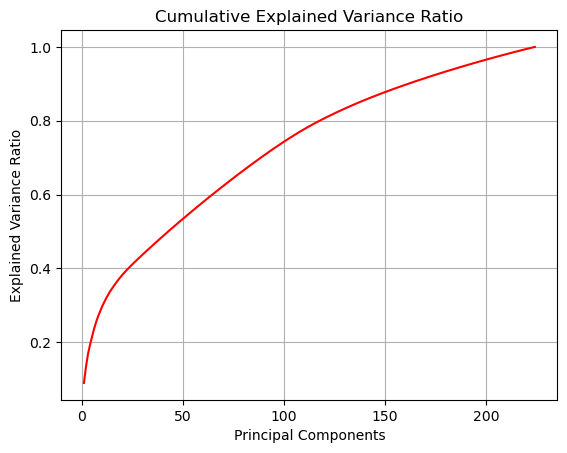

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

rnd_seed = 42
n_splits = 5

# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.plot(range(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_), color='red')
plt.title('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()

From the diagram above, we can see that the Cumulative Explained Variance Ratio is a strictly increasing function without any "elbow" in the curve (so, the rate of increase in explained variance never slows down significantly). This indicates that all features contribute significantly to the classification process, and reducing them would result in the loss of important information.

Now that we have performed a brief inspection of the data, we are ready to begin implementing our model. This notebook will follow a *step-by-step approach* to building the model, allowing us to track the thought process and decisions that lead to the final model.


## Advanced Data Inspection

To better understand how separable our classes are, we will create a UMAP (*Uniform Manifold Approximation and Projection*) 2D plot of our training data. UMAP is a ***dimensionality reduction technique*** that is particularly well-suited for visualizing high-dimensional data in two (or three dimensions). It aims to preserve both the local and global structure of the data, making it a useful tool for exploring the relationships between samples in a dataset.

The resulting UMAP visualization provides insights into the separability of the classes. If distinct clusters corresponding to different classes are visible, it suggests that the classes are ***well-separated*** in the feature space. Conversely, overlapping clusters may indicate that the classes are less distinguishable and could require *more advanced modeling techniques* to achieve accurate classification.


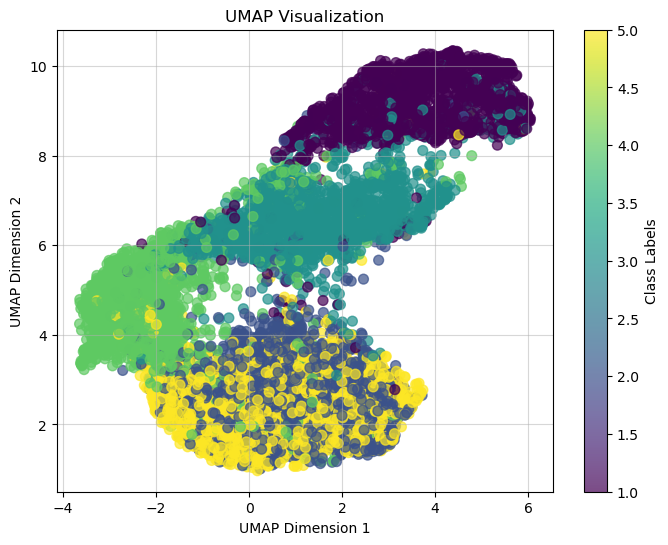

In [24]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, 
                         random_state=42, 
                         n_neighbors=15, 
                         min_dist=0.1, 
                         n_jobs=1)
X_umap = umap_reducer.fit_transform(X_scaled)

# Plot the UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Class Labels')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(alpha=0.5)
plt.show()

The plot above reveals several key insights about the separability of the classes:

- Class $\omega_1$ is almost completely distinct from the others, suggesting that it will be relatively *easy to classify*.  
- Classes $3$ and $4$ exhibit some overlap, but it is not extreme, making their classification *moderately challenging*.  
- Classes 2 and 5, however, are significantly intertwined in the 2D visualization, indicating that distinguishing between these two classes might be *particularly difficult*.

These observations suggest that additional attention may be needed for classes 2 and 5. Specifically, a ***specialized model*** designed to differentiate between these two classes could improve overall classification performance.

With this knowledge in mind, we can begin implementing simple classifiers.  


## Our first classifiers

In this section, we introduce some classifiers we implemented to test our hypothesis about the classification difficulty for each class. Using different models independently allows us to evaluate their performance and identify which ones are worth pursuing further. By focusing on the models that achieve higher accuracy, we can refine our approach and discard those that do not perform well. 

*Below, we present the classifiers that yielded the highest accuracy in our initial experiments.*


### KNN Classifier

Best parameters:  {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}
Best cross-validation score:  0.826
Average CV score: 0.826 (+/- 0.012)
Accuracy of KNN in test data: 0.8193


<Figure size 1200x1000 with 0 Axes>

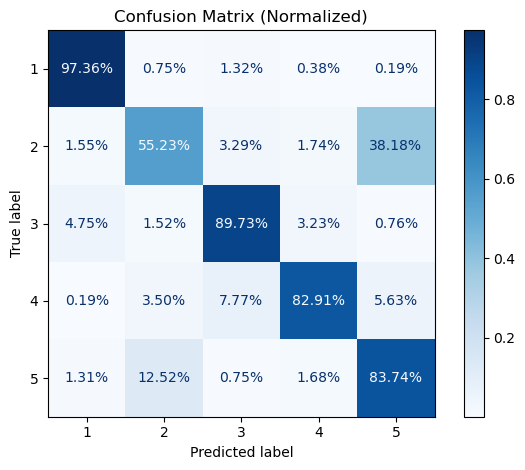

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

####### Step 1: Data splitting
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3,
    stratify=y  # Ensure balanced split across all 5 classes
)

####### Step 2: Perform grid search to find optimal k
param_grid = {
    'n_neighbors': [5, 7, 10, 11, 12],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

base_knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    base_knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", f"{grid_search.best_score_:.3f}")

####### Step 3: Get the best model and cross-validate
best_knn = grid_search.best_estimator_

# Perform k-fold cross-validation
cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=5)
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

####### Step 4: Train the model with best parameters and make predictions
best_knn.fit(X_train_scaled, y_train)
y_pred = best_knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN in test data: {accuracy:.4f}")

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Create figure with larger size
plt.figure(figsize=(12, 10))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='.2%')
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()

*Explanation of the steps in our KNN classification:*

1. **Data Splitting**
   - We take already scaled data (X_scaled) and split it into training and test sets
   - Using 70/30 split ratio with stratification to maintain class distribution
   - Stratification is particularly important since we have 5 classes

2. **Hyperparameter Optimization**
   - Using GridSearchCV to find the best parameters
   - Testing different values e.g.:
     - Number of neighbors (k)
     - Weight functions
     - Distance metrics
   - Using 5-fold cross-validation during the search

3. **Model Validation**
   - Taking the best model from grid search
   - Performing 5-fold cross-validation to assess model stability
   - Reporting mean accuracy and standard deviation

4. **Final Training and Evaluation**
   - Training the best model on the full training set
   - Making predictions on test data
   - Evaluating performance using:
     - Overall accuracy score
     - Normalized confusion matrix visualization

For the next classifiers, we will use them with preset parameters (without performing any hyperparameter tuning) and simply evaluate their accuracy on a test set.  

The purpose of this step is to gain an initial understanding of the underlying patterns in the data. By implementing simple but efficient models (with a total accuracy of more than 80%), we can identify which classifiers are promising and worth further exploration.  

This approach allows us to focus on the *general behavior* of the models without getting stucked in parameter optimization at this stage.


### Random Forest Classifier

Accuracy of Random Forest Classifier: 0.8200533739992375


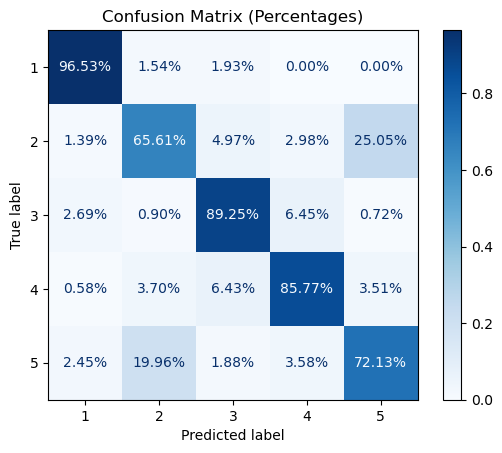

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate synthetic dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3,
    stratify=y  # Ensure balanced split across all 5 classes
)

# Define base estimator (KNN)
clf = RandomForestClassifier(n_estimators=100, bootstrap=True)

# Train BaggingClassifier
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Random Forest Classifier: {accuracy}")

# Compute and normalize the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true label count

# Customize the ConfusionMatrixDisplay for percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', values_format=".2%")  # Format as percentages
plt.title('Confusion Matrix (Percentages)')
plt.show()

### Multilayer Perceptron (MLP)

Accuracy for MLP: 0.808234845596645


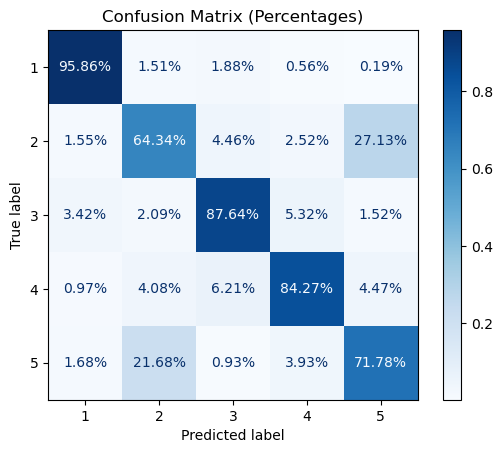

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3,
    stratify=y  # Ensure balanced split across all 5 classes
)

# Initialize the MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(50, 30),  # Two hidden layers with 50 and 30 neurons
    activation='relu',                    # Activation function for hidden layers
    solver='adam',                        # Optimization algorithm
    max_iter=500,                         # Maximum number of iterations
)

# Train the model
mlp.fit(X_train_scaled, y_train)

# Make predictions
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for MLP: {accuracy}")

# Compute and normalize the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true label count

# Customize the ConfusionMatrixDisplay for percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', values_format=".2%")  # Format as percentages
plt.title('Confusion Matrix (Percentages)')
plt.show()

### SVM

Average SVM Accuracy: 0.8532


<Figure size 1000x800 with 0 Axes>

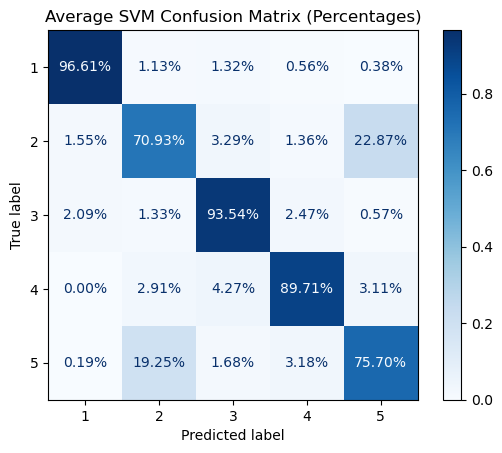

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Number of iterations for averaging
num_iterations = 1
accumulated_cm = None
total_accuracy = 0

# Calculate balanced class weights based on the class distribution
class_counts = [1769, 1720, 1754, 1716, 1784]
n_samples = sum(class_counts)
class_weights = {i+1: n_samples/(len(class_counts) * count) for i, count in enumerate(class_counts)}

# Hyperparameters for SVM
svm_params = {
    'C': 10,
    'kernel': 'rbf',  # Radial basis function kernel
    'class_weight': class_weights,
    'gamma': 'scale',  # Automatically scales gamma based on n_features * X.var()
    'probability': True  # Enable probability estimates
}

for iteration in range(num_iterations):
    # Split and preprocess data
    X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
        X_scaled, y, 
        test_size=0.3,
        stratify=y  # Ensure balanced split across all 5 classes
    )
    
    # Train and predict
    clf = SVC(**svm_params)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    total_accuracy += accuracy
    
    # Compute normalized confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    
    # Accumulate confusion matrices
    if accumulated_cm is None:
        accumulated_cm = cm
    else:
        accumulated_cm += cm

# Calculate averages
average_cm = accumulated_cm / num_iterations
average_accuracy = total_accuracy / num_iterations

print(f"Average SVM Accuracy: {average_accuracy:.4f}")

# Visualize the average confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=average_cm, 
                             display_labels=np.arange(1, 6))  # Labels 1-5
disp.plot(cmap='Blues', values_format='.2%')
plt.title('Average SVM Confusion Matrix (Percentages)')
plt.show()

All the results align with our initial hypothesis:  

- Classes $\omega_1$, $\omega_2 + \omega_5$, and $\omega_3 + \omega_4$ are relatively easy to classify.  
- With a properly tuned SVM (Support Vector Machine), we propably can also achieve a decent separation between $\omega_3$ and $\omega_4$.  
- However, distinguishing between $\omega_2$ and $\omega_5$ remains a challenge.  

Based on our experiments, we conclude that an SVM is an excellent initial choice for the main classification model.  


## Building the Model:

1. Use an SVM to classify the data into the following categories:  
   - $\omega_1$  
   - $\omega_2 + \omega_5$  
   - $\omega_3$  
   - $\omega_4$  

2. After this initial classification, employ a second, specialized classifier trained specifically to differentiate between $\omega_2$ and $\omega_5$.  

This two-step approach leverages the strengths of the SVM for general classification and refines performance with a focused model for the more challenging classes.


### SVM With Hyperparameter Tuning

Average CV score: 0.933 (+/- 0.016)
Accuracy of SVM on test data: 0.9340


<Figure size 1200x1000 with 0 Axes>

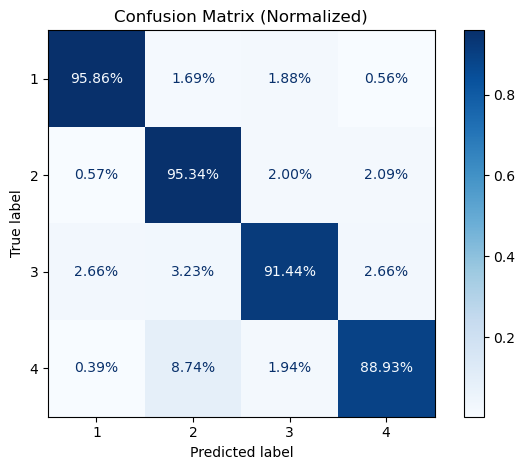

[1 5 3 ... 2 3 4]


In [110]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flag to toggle hyperparameter tuning
tune_params = False

####### Step 0: Function to merge classes
def merge_classes(y):
    y_merged = y.copy()
    y_merged[y_merged == 5] = 2  # Merge class 5 into 2
    return y_merged

# Get the merged classes for initial class weight calculation
y_merged = merge_classes(y)
unique_classes, class_counts = np.unique(y_merged, return_counts=True)
n_samples = sum(class_counts)
class_weights = {label: n_samples / (len(unique_classes) * count)
                 for label, count in zip(unique_classes, class_counts)}

####### Step 1: Data splitting
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    stratify=y_merged  # Ensure balanced split across all classes
)

y_train_init = y_train
y_test_init = y_test

# Merge classes in both training and test sets
y_train = merge_classes(y_train)
y_test = merge_classes(y_test)

####### Step 2: Select parameters (fixed or tuned)
if tune_params:
    # Perform grid search to find optimal parameters
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 0.01],
    }
    base_svm = SVC(kernel='rbf',
                   probability=True,
                   class_weight={1:3, 2:1, 3:3, 4:3},
                   random_state=42)
    grid_search = GridSearchCV(
        base_svm,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    # Print best parameters
    print("Best parameters: ", grid_search.best_params_)
    print("Best cross-validation score: ", f"{grid_search.best_score_:.3f}")
    # Get the best model
    best_svm = grid_search.best_estimator_
else:
    # Use fixed values for C and gamma
    fixed_C = 10
    fixed_gamma = 'scale'
    best_svm = SVC(kernel='rbf',
                   C=fixed_C,
                   gamma=fixed_gamma,
                   probability=True,
                   class_weight={1:3, 2:1, 3:3, 4:3},
                   random_state=42)

####### Step 3: Cross-validate and train the model
# Perform k-fold cross-validation
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5)
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train the model with selected parameters
best_svm.fit(X_train_scaled, y_train)

####### Step 4: Make predictions and evaluate
y_pred = best_svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of SVM on test data: {accuracy:.4f}")

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='.2%')
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()

print(y_test_init)

From the above results, we observe that splitting the classes into $\omega_1$, $\omega_2' = \omega_2 + \omega_5$, $\omega_3$, and $\omega_4$ can be effectively achieved using an SVM. However, we also notice that many samples (more than 5%) from the class $\omega_4$ are misclassified as belonging to $\omega_2'$.  

To address this issue, we propose introducing an additional binary SVM classifier to refine the classification process:  
1. **Step 1**: Use the initial SVM to classify a sample into one of the primary categories ($\omega_1$, $\omega_2'$, $\omega_3$, or $\omega_4$).  
2. **Step 2**: ***If a sample is classified as $\omega_2'$***:  
   - Use a binary SVM to determine if the sample belongs to $\omega_4$. This binary SVM should be able to be more precise while predicting the class $\omega_4$.
   - If the sample ***does not*** belong to $\omega_4$, we assume we made the classification correct, otherwise we change our estimation to $\omega_4$.

This hierarchical approach allows us to iteratively refine the classification process, ensuring higher accuracy for misclassified samples and improving overall performance. To run the next code, make sure you already run the previous code cell first:
 

Number of components selected by PCA: 121
Accuracy of Improved Classifier on test data: 0.9386


<Figure size 1200x1000 with 0 Axes>

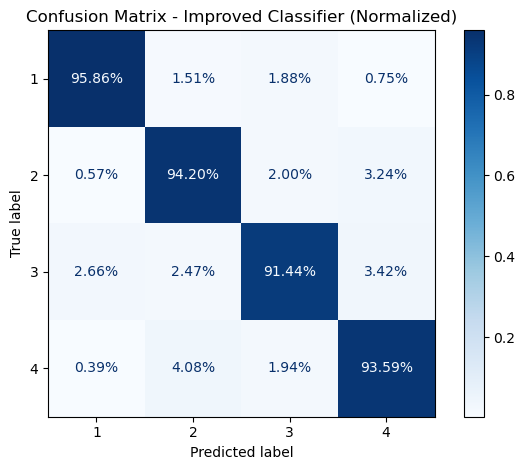


Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       531
           2       0.96      0.94      0.95      1051
           3       0.92      0.91      0.92       526
           4       0.90      0.94      0.92       515

    accuracy                           0.94      2623
   macro avg       0.93      0.94      0.94      2623
weighted avg       0.94      0.94      0.94      2623


Detailed analysis of Class 2 vs 4 predictions:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.98      0.94      0.96      1051
           3       0.00      0.00      0.00         0
           4       0.93      0.94      0.94       515

    accuracy                           0.94      1566
   macro avg       0.48      0.47      0.47      1566
weighted avg       0.96      0.94      0.95      1566


Final prediction distribution:
Classes: [1 2 3 4]
Counts:

c:\Users\arisd\anaconda3\envs\PRenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arisd\anaconda3\envs\PRenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arisd\anaconda3\envs\PRenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [111]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def merge_classes(y):
    y_merged = y.copy()
    y_merged[y_merged == 5] = 2
    return y_merged

def get_binary_subset(X, y):
    """Extract only samples belonging to classes 2 and 4"""
    mask = (y == 2) | (y == 4)
    return X[mask], y[mask]

class ImprovedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, svm_model1):
        self.svm_model1 = svm_model1
        # Initialize second SVM with stronger class weights
        self.svm_model2 = SVC(kernel='rbf',
                             C=100,
                             gamma='scale',
                             probability=True,
                             # Make misclassifying class 4 even more costly
                             class_weight={2: 1, 4: 3},
                             random_state=42)
        # Initialize PCA
        self.pca = PCA(n_components=0.80)  # Keep 95% of variance
        
    def fit(self, X, y):
        # Get only class 2 and 4 samples for training second SVM
        X_binary, y_binary = get_binary_subset(X, y)
        
        # Fit and transform PCA on binary subset
        X_binary_pca = self.pca.fit_transform(X_binary)
        print(f"Number of components selected by PCA: {X_binary_pca.shape[1]}")
        
        # Fit the second SVM on PCA-transformed data
        if len(np.unique(y_binary)) > 1:
            self.svm_model2.fit(X_binary_pca, y_binary)
        
        return self
        
    def predict(self, X):
        # Get initial predictions from first SVM
        initial_predictions = self.svm_model1.predict(X)
        
        # Only double-check samples predicted as class 2
        class_2_mask = (initial_predictions == 2)
        final_predictions = initial_predictions.copy()
        
        if np.any(class_2_mask):
            # Get subset of samples predicted as class 2
            X_subset = X[class_2_mask]
            
            # Transform subset using fitted PCA
            X_subset_pca = self.pca.transform(X_subset)
            
            # Get probability estimates from second SVM
            prob_predictions = self.svm_model2.predict_proba(X_subset_pca)
            
            # Get the probability for class 4
            class_4_probs = prob_predictions[:, 1]  # Assuming class 4 is index 1
            
            # Use an even lower threshold for class 4 to catch more of them
            class_4_mask = class_4_probs > 0.3  # More aggressive threshold
            
            # Create array of predictions based on probabilities
            secondary_predictions = np.where(class_4_mask, 4, 2)
            
            # Update predictions
            final_predictions[class_2_mask] = secondary_predictions
            
        return final_predictions

def evaluate_improved_classifier(X_train_scaled, X_test_scaled, y_train, y_test, svm_model1):
    # Initialize and fit the improved classifier
    improved_clf = ImprovedClassifier(svm_model1)
    improved_clf.fit(X_train_scaled, y_train)
    
    # Get predictions
    y_pred_improved = improved_clf.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_improved)
    print(f"Accuracy of Improved Classifier on test data: {accuracy:.4f}")
    
    # Plot confusion matrix
    display_labels = sorted(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred_improved, 
                         labels=display_labels, normalize='true')
    
    plt.figure(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=display_labels)
    disp.plot(cmap='Blues', values_format='.2%')
    plt.title('Confusion Matrix - Improved Classifier (Normalized)')
    plt.tight_layout()
    plt.show()
    
    # Print detailed report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_improved))
    
    # Analyze specifically class 2/4 confusion
    mask_2_4 = (y_test == 2) | (y_test == 4)
    if np.any(mask_2_4):
        print("\nDetailed analysis of Class 2 vs 4 predictions:")
        y_test_binary = y_test[mask_2_4]
        y_pred_binary = y_pred_improved[mask_2_4]
        print(classification_report(y_test_binary, y_pred_binary))
    
    return y_pred_improved

# Create and evaluate the improved classifier
y_pred_final = evaluate_improved_classifier(
    X_train_scaled, X_test_scaled, y_train, y_test, best_svm
)

classes, counts = np.unique(y_pred_final, return_counts=True)
print(f'\nFinal prediction distribution:')
print(f'Classes: {classes}')
print(f'Counts: {counts}')

As is evident, we have successfully addressed the challenge of misclassified class $\omega_4$, improving the accuracy of the model and ensuring better classification performance for this class.

The remaining challenge is distinguishing between classes 2 and 5, which are combined into $\omega_2 + \omega_5$ during the first classification step.


## Proposed Solution for Distinguishing $\omega_2$ and $\omega_5$

As mentioned earlier, a simple and efficient way to address this issue is by introducing a new binary classifier. This binary classifier will be used specifically when the SVM from the first step classifies a sample as belonging to $\omega_2 + \omega_5$ (and after we check that this sample does not belong to class $\omega_4$).

The goal of this secondary classifier is to achieve higher accuracy in distinguishing $\omega_2$ from $\omega_5$ than the primary SVM, even after hyperparameter tuning.


Before implementing the binary classifiers, we will first explore various transformations of the feature vectors to evaluate whether these transformations can improve the separability of classes 2 and 5.  

By analyzing these transformations, we aim to identify patterns or relationships within the data that might enhance the performance of the binary classifier. This step helps us better understand the data and ensures we leverage the most effective feature representations for distinguishing between the two classes.


c:\Users\arisd\anaconda3\envs\PRenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

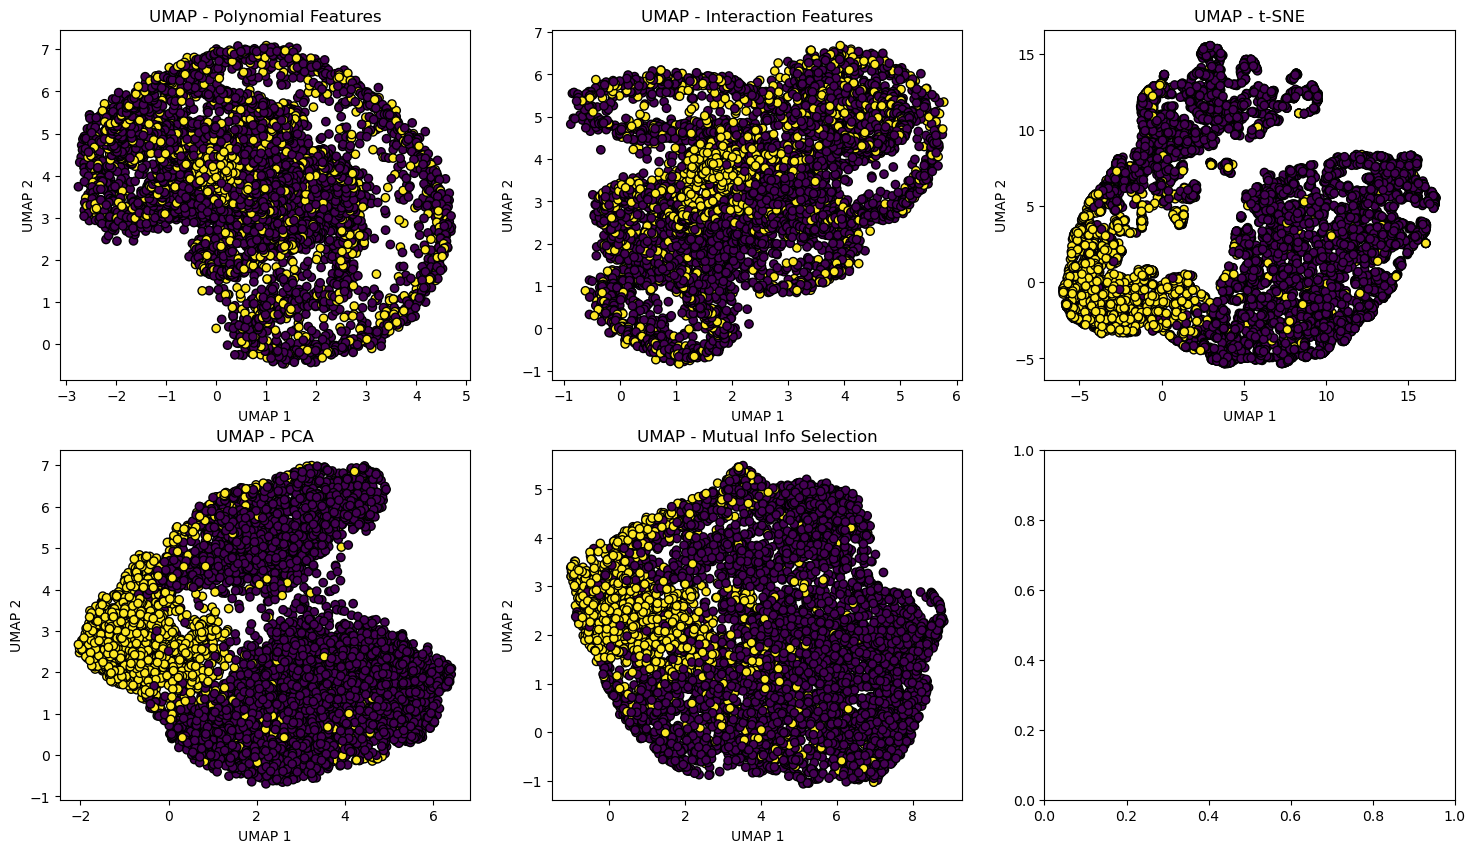

In [10]:
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

####### Step 0: Function to exclude and merge classes
def preprocess_classes(X, y):
    # Exclude class 1
    mask = y != 1  # Keep all samples not belonging to class 1
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    # Merge classes 3 and 2 into class 2
    y_filtered = np.where(y_filtered == 3, 2, y_filtered)
    # Merge classes 2 and 5 into class 2
    y_filtered = np.where(y_filtered == 5, 2, y_filtered)
    return X_filtered, y_filtered

# Apply preprocessing
X_preprocessed, y_preprocessed = preprocess_classes(X_scaled, y)

# Initialize UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)

# List of the different transformations
transformations = {
    "Polynomial Features": PolynomialFeatures(degree=2, include_bias=False),
    "Interaction Features": PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    "t-SNE": TSNE(n_components=2, random_state=42),
    "PCA": PCA(n_components=0.95),
    "Mutual Info Selection": SelectKBest(mutual_info_classif, k=50),
    "RFE (SVC)": RFE(estimator=SVC(kernel='linear'), n_features_to_select=50, step=1)
}

# Create a figure for the plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loop through transformations and apply UMAP, then plot
for i, (name, transformer) in enumerate(transformations.items()):
    # Transform the data
    if name == "t-SNE":
        X_transformed = transformer.fit_transform(X_preprocessed)  # For t-SNE, we use it directly
    else:
        X_transformed = transformer.fit_transform(X_preprocessed, y_preprocessed)
    
    # Apply UMAP to the transformed data
    X_umap = umap_model.fit_transform(X_transformed)
    
    # Plot
    ax = axes[i // 3, i % 3]
    ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y_preprocessed, cmap='viridis', edgecolors='k')
    ax.set_title(f"UMAP - {name}")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()


### Final Model:

Number of components selected by PCA: 118
Number of components selected by PCA (2 vs 5): 137

Accuracy of Complete Pipeline on test data: 0.8456


<Figure size 1200x1000 with 0 Axes>

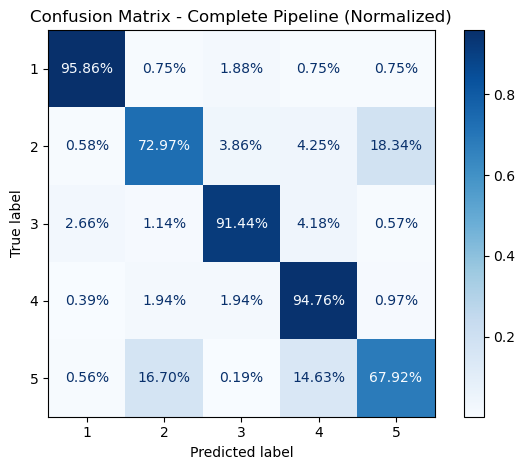


Complete Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       531
           2       0.78      0.73      0.75       518
           3       0.92      0.91      0.92       526
           4       0.79      0.95      0.86       515
           5       0.77      0.68      0.72       533

    accuracy                           0.85      2623
   macro avg       0.84      0.85      0.84      2623
weighted avg       0.85      0.85      0.84      2623


Detailed analysis of Class 2 vs 5 predictions:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.81      0.73      0.77       518
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.79      0.68      0.73       533

    accuracy                           0.70      1051
   macro avg       0.32      0.28      0.30      1

c:\Users\arisd\anaconda3\envs\PRenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arisd\anaconda3\envs\PRenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arisd\anaconda3\envs\PRenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [125]:
# First, keep all existing code unchanged
# Then add the following new code:

class FinalStageClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, improved_classifier):
        self.improved_classifier = improved_classifier
        # Initialize third SVM specifically for class 2 vs 5
        self.svm_model3 = SVC(kernel='rbf',
                              C=100,
                              gamma='scale',
                              probability=True,
                              random_state=42)
        # Initialize PCA for 2 vs 5 separation
        self.pca3 = PCA(n_components=0.85)
        self.has_2_5_classifier = False
        
    def fit(self, X, y):
        # First fit the improved classifier (1,2+5,3,4)
        self.improved_classifier.fit(X, y)
        
        # Prepare data for 2 vs 5 classifier
        mask_2_5 = (y == 2) | (y == 5)
        if np.any(mask_2_5):
            X_2_5 = X[mask_2_5]
            y_2_5 = y[mask_2_5]
            
            if len(np.unique(y_2_5)) > 1:
                # Transform data using PCA
                X_2_5_pca = self.pca3.fit_transform(X_2_5)
                print(f"Number of components selected by PCA (2 vs 5): {X_2_5_pca.shape[1]}")
                
                # Create binary labels (2=0, 5=1)
                y_2_5_binary = (y_2_5 == 5).astype(int)
                self.svm_model3.fit(X_2_5_pca, y_2_5_binary)
                self.has_2_5_classifier = True
            else:
                print("Warning: Not enough classes for 2 vs 5 classifier")
                self.has_2_5_classifier = False
        
        return self
        
    def predict(self, X):
        # Get predictions from improved classifier (1,2+5,3,4)
        predictions = self.improved_classifier.predict(X)
        
        # Only process samples predicted as class 2
        if self.has_2_5_classifier:
            class_2_mask = (predictions == 2)
            if np.any(class_2_mask):
                X_subset = X[class_2_mask]
                X_subset_pca = self.pca3.transform(X_subset)
                
                # Get probabilities for class 5
                proba_2_5 = self.svm_model3.predict_proba(X_subset_pca)
                class_5_probs = proba_2_5[:, 1]
                
                # Use probability threshold to decide class 5
                class_5_mask = class_5_probs > 0.5
                predictions[class_2_mask] = np.where(class_5_mask, 5, 2)
        
        return predictions

def evaluate_complete_pipeline(X_train_scaled, X_test_scaled, y_train, y_test, svm_model1):
    # Create the complete pipeline
    improved_clf = ImprovedClassifier(svm_model1)
    final_clf = FinalStageClassifier(improved_clf)
    
    # Fit the complete pipeline
    final_clf.fit(X_train_scaled, y_train)
    
    # Get predictions
    y_pred_final = final_clf.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_final)
    print(f"\nAccuracy of Complete Pipeline on test data: {accuracy:.4f}")
    
    # Plot confusion matrix
    display_labels = sorted(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred_final, 
                          labels=display_labels, normalize='true')
    
    plt.figure(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=display_labels)
    disp.plot(cmap='Blues', values_format='.2%')
    plt.title('Confusion Matrix - Complete Pipeline (Normalized)')
    plt.tight_layout()
    plt.show()
    
    # Print detailed report
    print("\nComplete Classification Report:")
    print(classification_report(y_test, y_pred_final))
    
    # Analyze specifically class 2/5 confusion
    mask_2_5 = (y_test == 2) | (y_test == 5)
    if np.any(mask_2_5):
        print("\nDetailed analysis of Class 2 vs 5 predictions:")
        y_test_binary = y_test[mask_2_5]
        y_pred_binary = y_pred_final[mask_2_5]
        print(classification_report(y_test_binary, y_pred_binary))
    
    return y_pred_final

# Run the complete pipeline
y_pred_final = evaluate_complete_pipeline(
    X_train_scaled, X_test_scaled, y_train_init, y_test_init, best_svm
)

# Show final distribution
classes, counts = np.unique(y_pred_final, return_counts=True)
print(f'\nFinal prediction distribution:')
print(f'Classes: {classes}')
print(f'Counts: {counts}')
